In [ ]:
!pip install arabic-reshaper
import arabic_reshaper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
#from bidi.algorithm import get_display
import json

In [ ]:

# Load the data
df = pd.read_excel('Sala Attendance.xlsx')
# Convert Worker Phone column to integer
df['Worker Phone'] = pd.to_numeric(df['Worker Phone'], errors='coerce').astype('Int64')

# Function to add a default date and convert to datetime while handling errors, then format as 12-hour time
default_date = pd.Timestamp('today').normalize()  # Uses today's date

def convert_and_format(time_col):
    # Assuming time data is in 'HH:MM AM/PM' format
    time_format = '%I:%M %p'
    # Convert date and time to datetime format, specify format explicitly
    datetime_col = pd.to_datetime(df[time_col].apply(lambda x: f"{default_date.date()} {x}" if pd.notna(x) else None), format=f'%Y-%m-%d {time_format}', errors='coerce')
    return datetime_col.dt.strftime(time_format)  # Return in 12-hour format with AM/PM

# Apply conversion and formatting to each time column
df['Shift Start Time'] = convert_and_format('Shift Start Time')
df['Shift End Time'] = convert_and_format('Shift End Time')
df['Check-in Time'] = convert_and_format('Check-in Time')
df['Check-out Time'] = convert_and_format('Check-out Time')

# Function to determine delay status based on datetime comparisons and calculate delayed time
def update_status(row):
    # Convert formatted string back to datetime for comparison, using the same format used for formatting
    shift_start = pd.to_datetime(row['Shift Start Time'], format='%I:%M %p', errors='coerce')
    check_in = pd.to_datetime(row['Check-in Time'], format='%I:%M %p', errors='coerce')
    shift_end = pd.to_datetime(row['Shift End Time'], format='%I:%M %p', errors='coerce')
    check_out = pd.to_datetime(row['Check-out Time'], format='%I:%M %p', errors='coerce')
    delay_time = None  # Initialize the delay time

    if pd.isna(check_in) or pd.isna(shift_start):
        return row['Status'], delay_time
    if (check_in - shift_start).total_seconds() > 900:
        delay_time = (check_in - shift_start).total_seconds() / 60  # Calculate delay in minutes
        return 'Delayed', delay_time
    if pd.isna(check_out) or pd.isna(shift_end):
        return row['Status'], delay_time
    if (check_out - shift_end).total_seconds() > 900:
        delay_time = (check_out - shift_end).total_seconds() / 60  # Calculate delay in minutes
        return 'Delayed', delay_time
    return row['Status'], delay_time

# Apply update_status and split results into two columns
df[['Status', 'Delayed Time in Minutes']] = df.apply(update_status, axis=1, result_type='expand')


df


,Branch,Worker,Worker Phone,Shift Date,Shift Start Time,Shift End Time,Check-in Time,Check-out Time,System Checkout,Status,Delayed Time in Minutes
0,"Boulvard,sala",سيف خالد التميمي,966558003307,2023-05-24,09:00 PM,01:00 AM,09:00 PM,01:00 AM,NaN,Finished,NaN
1,"Boulvard,sala",عبدالله عبدالعزيز العصيمي,966563239646,2023-05-24,09:00 PM,01:00 AM,09:00 PM,01:00 AM,Yes,Finished,NaN
2,"Boulvard,sala",محمد عبدالله سعيد عبيد,966557773504,2023-05-24,09:00 PM,01:00 AM,09:00 PM,01:00 AM,NaN,Finished,NaN
3,"Boulvard,sala",عبدالرحيم دخيل علي الهذلي,966536609404,2023-05-24,09:00 PM,01:00 AM,09:00 PM,01:00 AM,Yes,Finished,NaN
4,"Boulvard,sala",منصور علي فالح النخلي,966500879622,2023-05-24,09:00 PM,01:00 AM,09:00 PM,01:00 AM,Yes,Finished,NaN
...,...,...,...,...,...,...,...,...,...,...,...
19136,BBZ The View,سعاد بريد عمار الشمري,966552955502,2024-05-09,10:00 AM,06:00 PM,10:15 AM,06:00 PM,NaN,Finished,NaN
19137,BBZ The View,سارة خالد بن سعيد,966553526875,2024-05-09,05:00 PM,01:00 AM,05:21 PM,01:00 AM,Yes,Delayed,21.0
19138,BBZ The View,أثير بدر العنزي,966538515773,2024-05-09,05:00 PM,01:00 AM,05:00 PM,01:00 AM,Yes,Finished,NaN
19139,BBZ The View,الين السبيعي,966593991833,2024-05-09,05:00 PM,01:00 AM,05:00 PM,01:00 AM,NaN,Finished,NaN


In [ ]:

## Convert relevant columns to datetime
df['Shift Date'] = pd.to_datetime(df['Shift Date'], format='%Y-%m-%d')
df['Check-in Time'] = pd.to_datetime(df['Shift Date'].astype(str) + ' ' + df['Check-in Time'], format='%Y-%m-%d %I:%M %p')
df['Check-out Time'] = pd.to_datetime(df['Shift Date'].astype(str) + ' ' + df['Check-out Time'], format='%Y-%m-%d %I:%M %p')

# Adjust for shifts that end after midnight
df.loc[df['Check-out Time'] < df['Check-in Time'], 'Check-out Time'] += pd.Timedelta(days=1)

# Calculate the work duration in hours
df['Work Duration'] = (df['Check-out Time'] - df['Check-in Time']).dt.total_seconds() / 3600

# Extract year and month from Shift Date
df['YearMonth'] = df['Shift Date'].dt.to_period('M')

# Group by Worker Phone and YearMonth, then sum the work durations
df = df.groupby(['Worker Phone', 'YearMonth'])['Work Duration'].sum().reset_index()

# Sort by Worker Phone and YearMonth
df = df.sort_values(by=['Worker Phone', 'YearMonth'])

# Calculate the cumulative hours for each worker
df['Cumulative Hours'] = df.groupby('Worker Phone')['Work Duration'].cumsum()

# Rename columns for clarity
df.rename(columns={'YearMonth': 'Month'}, inplace=True)

# Save the modified DataFrame to a new Excel file
df.to_excel('cumulative_hours.xlsx', index=False)

df


KeyError: 'Shift Date'

In [ ]:

# Function to calculate median
def calculate_median(group):
    return group.median()

# Group by month and calculate median of cumulative hours
median_by_month = df.groupby('Month')['Cumulative Hours'].apply(calculate_median)

# Display the results
median_by_month


Month
2023-05     39.483333
2023-06     24.000000
2023-07     62.266667
2023-08    127.575000
2023-09    132.000000
2023-10    176.641667
2023-11    177.483333
2023-12    232.416667
2024-01    280.358333
2024-02    346.716667
2024-03    402.033333
2024-04    136.191667
2024-05    201.900000
Freq: M, Name: Cumulative Hours, dtype: float64

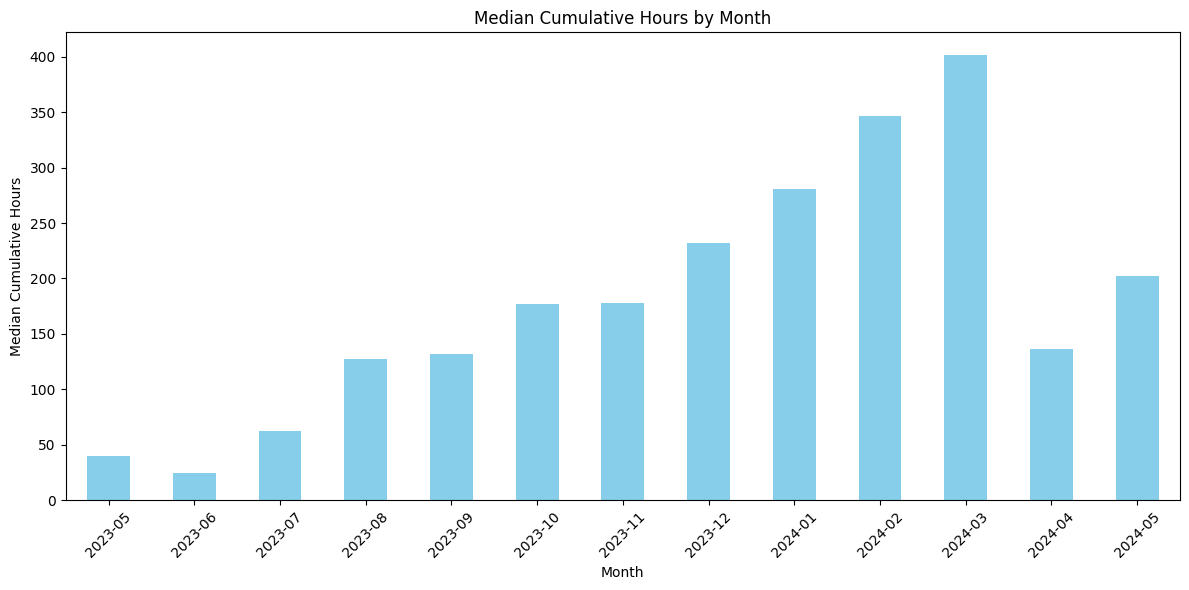

In [ ]:
import matplotlib.pyplot as plt

# Group by month and calculate median of cumulative hours
median_by_month = df.groupby('Month')['Cumulative Hours'].median()

# Plotting the results
plt.figure(figsize=(12, 6))
median_by_month.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Median Cumulative Hours')
plt.title('Median Cumulative Hours by Month')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:

# Load the JSON file

extracted_df = pd.read_json('Sala Workers.json')

# Display the columns
print(extracted_df.columns)


Index(['_id', 'profile', 'lifeTimeEarning', 'weeklyEarning', 'rating',
       'workExperience', 'updatedProfile', 'workerStatus', 'jobTypes',
       'notification',
       ...
       'training_certificates_updated_at', 'educations_updated_at',
       'health_certificate_updated_at', 'useSpecificWage', 'lockedBy',
       'specificWage', 'enhancedIntroduction', 'recommendation_weight',
       'verifiedBy', 'contract_ratings'],
      dtype='object', length=110)


In [87]:
import pandas as pd
import json

# Define the mappings
gender_mapping = {0: 'Male', 1: 'Female'}
education_mapping = {
    0: 'no_education',
    1: 'intermediate_and_lower',
    2: 'high_school',
    3: 'diploma',
    4: 'college_student',
    5: 'bachelor',
    6: 'master',
    7: 'phd'
}

# Load the JSON file
json_file_path = 'Sala Workers.json'  # Replace with your actual file path

# Read the JSON file into a DataFrame
extracted_df = pd.read_json(json_file_path)

extracted_df


,_id,profile,lifeTimeEarning,weeklyEarning,rating,workExperience,updatedProfile,workerStatus,jobTypes,notification,...,training_certificates_updated_at,educations_updated_at,health_certificate_updated_at,useSpecificWage,lockedBy,specificWage,enhancedIntroduction,recommendation_weight,verifiedBy,contract_ratings
0,5d350802c7bc3f1a5b6a3a7a,{'picture': 'https://shiftat-aws-s3.s3.amazona...,0,0,0.0,"[5d1b3a5a1dc7610693145b0f, 5d1b3abf1dc76106931...",True,0,"[5d1b39641dc7610693145b09, 5d1cbf051dc76106931...",False,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5d3fab03e04080799b760788,{'picture': 'https://gravatar.com/avatar/?s=20...,0,0,0.0,"[5d1b3a5a1dc7610693145b0f, 5d1b3aa61dc76106931...",True,0,[],True,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5d770c2ab7a4d95b8c4a98bf,"{'name': 'Shahad Saud ', 'gender': 1, 'email':...",0,0,0.0,"[5d1b3a5a1dc7610693145b0f, 5d1b3aa61dc76106931...",True,0,"[5d1b39641dc7610693145b09, 5d1cbf051dc76106931...",True,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5e39843e023a5f53901bf9d2,{'picture': 'https://shiftat-aws-s3.s3.amazona...,0,0,0.0,[],True,0,[],True,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5f456e8a03d82760f7e3376b,"{'name': 'طيف عياد السميري ', 'gender': 1, 'em...",0,0,0.0,[],True,0,[],True,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,662530c031f9351dbc0ff4db,{'picture': 'https://gravatar.com/avatar/?s=20...,0,0,0.0,[],True,0,[],True,...,2024-04-21 15:38:30.452000+00:00,2024-04-21 15:31:03.855000+00:00,NaT,0.0,NaN,NaN,NaN,NaN,NaN,"{'appearance': {'total': 0, 'count': 0}, 'comm..."
1070,6625dd2b31f9351dbc146256,{'picture': 'https://shiftat-aws-s3.s3.amazona...,0,0,0.0,[],True,0,[],True,...,2024-04-22 03:51:49.657000+00:00,2024-04-22 03:46:32.635000+00:00,NaT,0.0,NaN,NaN,NaN,NaN,NaN,"{'appearance': {'total': 0, 'count': 0}, 'comm..."
1071,662e327d1779022d8e6eb8f4,{'picture': 'https://shiftat-aws-s3.s3.amazona...,0,0,0.0,[],True,0,[],True,...,NaT,2024-04-28 11:28:59.176000+00:00,NaT,0.0,NaN,NaN,NaN,NaN,NaN,"{'appearance': {'total': 0, 'count': 0}, 'comm..."
1072,662fdbac1779022d8e77965b,{'picture': 'https://shiftat-aws-s3.s3.amazona...,0,0,0.0,[],True,0,[],True,...,NaT,2024-04-29 17:42:42.734000+00:00,NaT,0.0,NaN,NaN,NaN,NaN,NaN,"{'appearance': {'total': 0, 'count': 0}, 'comm..."


In [126]:
import pandas as pd
import json

# Define the mappings
gender_mapping = {0: 'Male', 1: 'Female'}
education_mapping = {
    0: 'no_education',
    1: 'intermediate_and_lower',
    2: 'high_school',
    3: 'diploma',
    4: 'college_student',
    5: 'bachelor',
    6: 'master',
    7: 'phd'
}

# Load the JSON file
json_file_path = 'Sala Workers.json'  # Replace with your actual file path

# Read the JSON file into a DataFrame
extracted_df = pd.read_json(json_file_path)

extracted_df



# Recursive function to search for the phone key anywhere in the JSON object
def find_phone(json_obj):
    if isinstance(json_obj, dict):
        for key, value in json_obj.items():
            if key == 'phone':
                return str(value)  # Ensure phone is treated as string
            elif isinstance(value, (dict, list)):
                result = find_phone(value)
                if result is not None:
                    return result
    elif isinstance(json_obj, list):
        for item in json_obj:
            result = find_phone(item)
            if result is not None:
                return result
    return None



extracted_df['Name'] = extracted_df['profile'].apply(lambda x: x.get('name'))
extracted_df['Gender'] = extracted_df['profile'].apply(lambda x: gender_mapping.get(x.get('gender')))
extracted_df['Worker_Phone'] = extracted_df.apply(lambda row: find_phone(row.to_dict()), axis=1)
extracted_df['DateOfBirth'] = pd.to_datetime(extracted_df['dateOfBirth']).dt.date
extracted_df['TotalFinishedHours'] = extracted_df['totalFinishedHours']
extracted_df['TotalAbsenseHours'] = extracted_df['totalAbsenseHours']
extracted_df['TotalLateHours'] = extracted_df['totalLateHours']
extracted_df['Age'] = (pd.to_datetime('2024-07-02') - pd.to_datetime(extracted_df['DateOfBirth'])).dt.days // 365
# Create a new column for the "on time" status
extracted_df['On_Time'] = ['on time' if hrs == 0 else 'not on time' for hrs in extracted_df['TotalLateHours']]

# Extract education type from the educations list
def get_education_type(educations):
    for edu in educations:
        if 'type' in edu:
            return education_mapping.get(edu['type'])
    return None

extracted_df['Education'] = extracted_df['educations'].apply(get_education_type)

# Select the relevant columns and rename 'Phone' to 'Worker Phone'
extracted_df = extracted_df[['Name', 'Worker_Phone', 'Gender', 'Education', 'DateOfBirth', 'Age', 'TotalFinishedHours', 'TotalAbsenseHours', 'TotalLateHours', 'On_Time' ]]
# Convert Worker Phone column to integer
#extracted_df['Worker Phone'] = pd.to_numeric(df['Worker Phone'], errors='coerce').astype('Int64')



# Display the extracted DataFrame
extracted_df


,Name,Worker_Phone,Gender,Education,DateOfBirth,Age,TotalFinishedHours,TotalAbsenseHours,TotalLateHours,On_Time
0,ايوب علي يحي صميلي,966509569590,Male,college_student,2000-10-11,23.0,54.0,6.0,0.700000,not on time
1,سامي عبيد,966553909741,Male,college_student,1995-02-26,29.0,416.0,20.0,14.383333,not on time
2,Shahad Saud,966509483196,Female,college_student,2000-06-04,24.0,92.0,8.0,0.000000,on time
3,Abdulaziz Mansour Almutairi,966556764037,Male,high_school,2001-03-05,23.0,0.0,0.0,0.000000,on time
4,طيف عياد السميري,966569184372,Female,bachelor,1999-01-28,25.0,24.0,0.0,0.000000,on time
...,...,...,...,...,...,...,...,...,...,...
1069,طالب مبارك فضل الهمامي,966580970390,Male,high_school,2004-03-07,20.0,0.0,0.0,0.000000,on time
1070,عبدالله خالد الشايقي,966502015960,Male,high_school,1995-05-04,29.0,16.0,0.0,0.000000,on time
1071,اروى جميعان الشمري,966557038092,Female,bachelor,1999-05-11,25.0,32.0,0.0,0.000000,on time
1072,اثير مشعل محمد العتيبي,966532377989,Female,bachelor,1995-04-25,29.0,8.0,8.0,0.000000,on time


<Figure size 1200x600 with 0 Axes>

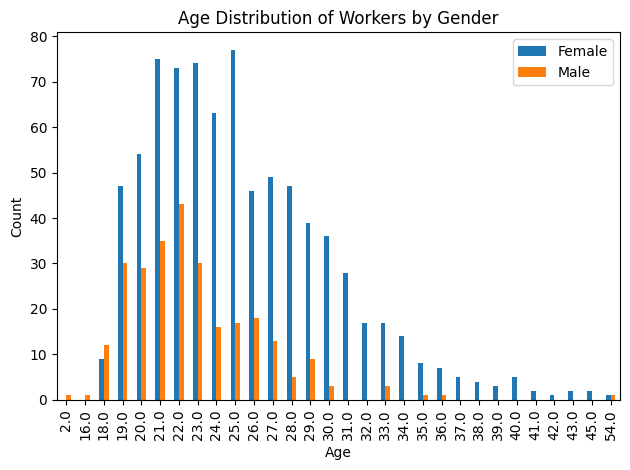

In [153]:
# @title Age Distribution of Workers
# 'Age' and 'Gender' are columns in the 'extracted_df' DataFrame
age_gender_counts = extracted_df.groupby(['Age', 'Gender']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
age_gender_counts.plot(kind='bar', title='Age Distribution of Workers by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
#plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(True)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

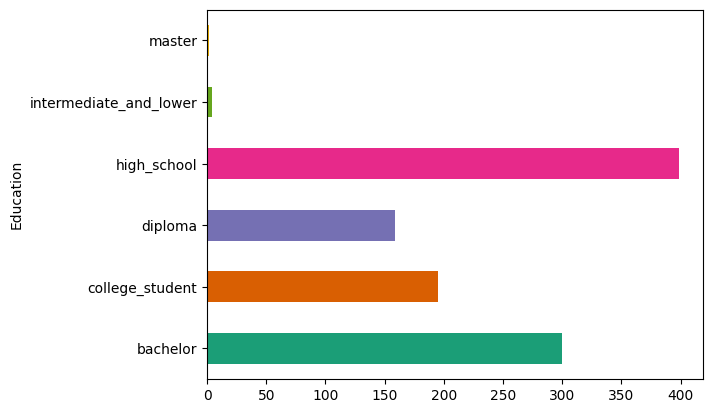

In [118]:
# @title Education

from matplotlib import pyplot as plt
import seaborn as sns
extracted_df.groupby('Education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(True)

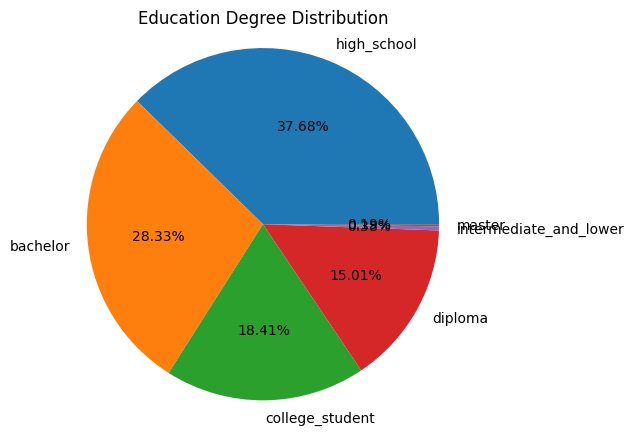

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Count the number of workers for each education level
education_counts = extracted_df['Education'].value_counts()

# Calculate the percentage distribution
education_percentages = (education_counts / education_counts.sum()) * 100

# Plot the education degree distribution as a pie chart
plt.figure(figsize=(5, 5))
plt.pie(education_percentages, labels=education_percentages.index, autopct='%.2f%%')
plt.title('Education Degree Distribution')
plt.axis('equal')
plt.show()

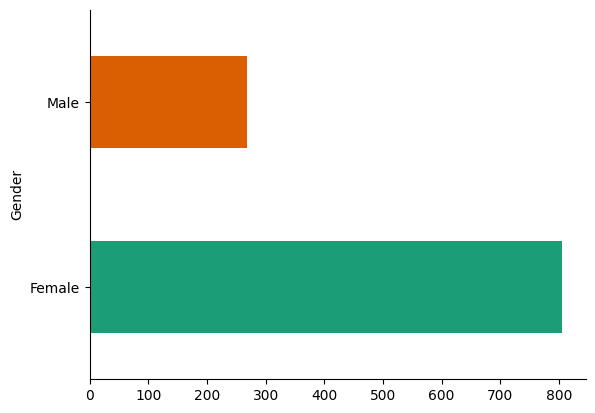

In [ ]:
# @title Gender

from matplotlib import pyplot as plt
import seaborn as sns
extracted_df.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

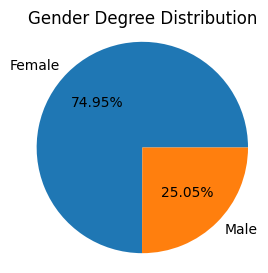

In [ ]:
# Count the number of workers for each education level
gender_counts = extracted_df['Gender'].value_counts()

# Calculate the percentage distribution
education_percentages = (gender_counts / gender_counts.sum()) * 100

# Plot the education degree distribution as a pie chart
plt.figure(figsize=(3,3))
plt.pie(education_percentages, labels=education_percentages.index, autopct='%.2f%%')
plt.title('Gender Degree Distribution')
plt.axis('equal')
plt.show()

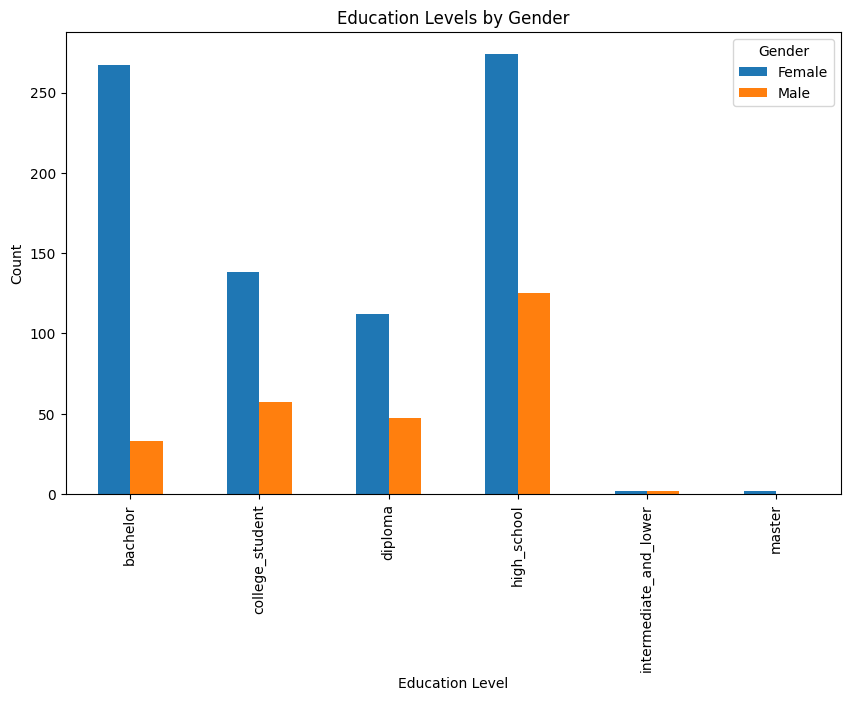

In [ ]:
education_counts = extracted_df.groupby(["Education", "Gender"]).size().unstack(fill_value=0)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
education_counts.plot(kind="bar", ax=ax)
ax.set_xlabel("Education Level")
ax.set_ylabel("Count")
ax.set_title("Education Levels by Gender")
ax.legend(title="Gender")
plt.show()

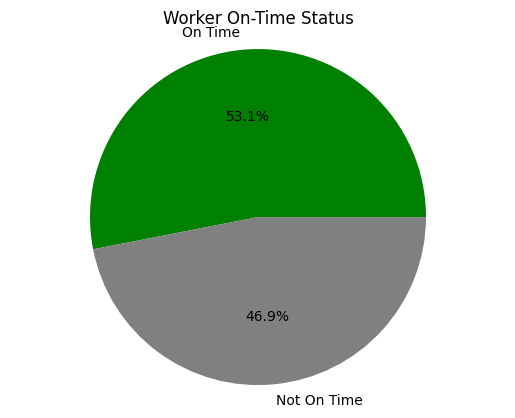

In [137]:
# Count the number of 'on time' and 'not on time' workers
on_time_count = len(extracted_df[extracted_df['On_Time'] == 'on time'])
not_on_time_count = len(extracted_df[extracted_df['On_Time'] == 'not on time'])

# Create the pie chart
labels = ['On Time', 'Not On Time']
sizes = [on_time_count, not_on_time_count]
colors = ['green', 'gray']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is circular.
plt.title('Worker On-Time Status')
plt.show()


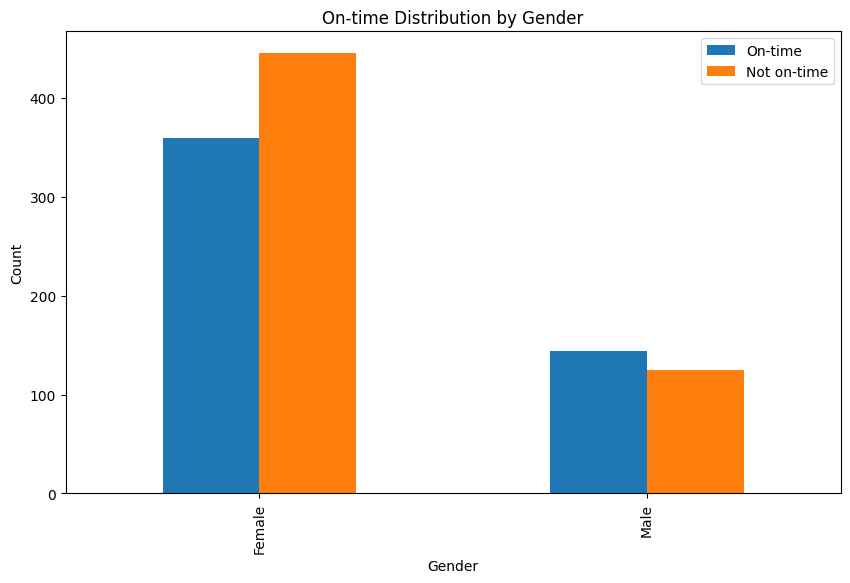

In [150]:
# Count on-time for each gender
on_time_counts = extracted_df.groupby(['Gender', 'On_Time']).size().unstack(fill_value=0)

# Plot the bar chart
on_time_counts.plot(kind='bar', figsize=(10, 6))
plt.title('On-time Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(['On-time', 'Not on-time'])
plt.show()

In [ ]:
import pandas as pd

# Merge DataFrames on 'Worker Phone'
merged_df = pd.concat([df, extracted_df[['Worker Phone', 'Gender', 'Education']]], ignore_index=True, sort=False)

# Save the merged DataFrame to a new Excel file
output_file_path = 'merged_output.xlsx'
merged_df.to_excel(output_file_path, index=False)

merged_df

,Name,Worker Phone,Gender,Education
0,ايوب علي يحي صميلي,966500033205,Male,college_student
1,سامي عبيد,966500043099,Male,college_student
2,Shahad Saud,966500068598,Female,college_student
3,Abdulaziz Mansour Almutairi,966500068598,Male,high_school
4,طيف عياد السميري,966500100119,Female,bachelor
...,...,...,...,...
1074,NaN,966538394234,Male,high_school
1075,NaN,966538394234,Male,high_school
1076,NaN,966538401639,Female,bachelor
1077,NaN,966538401639,Female,bachelor


## Highest Number of Employees by Branch

The total number of employees across all branches is 781.


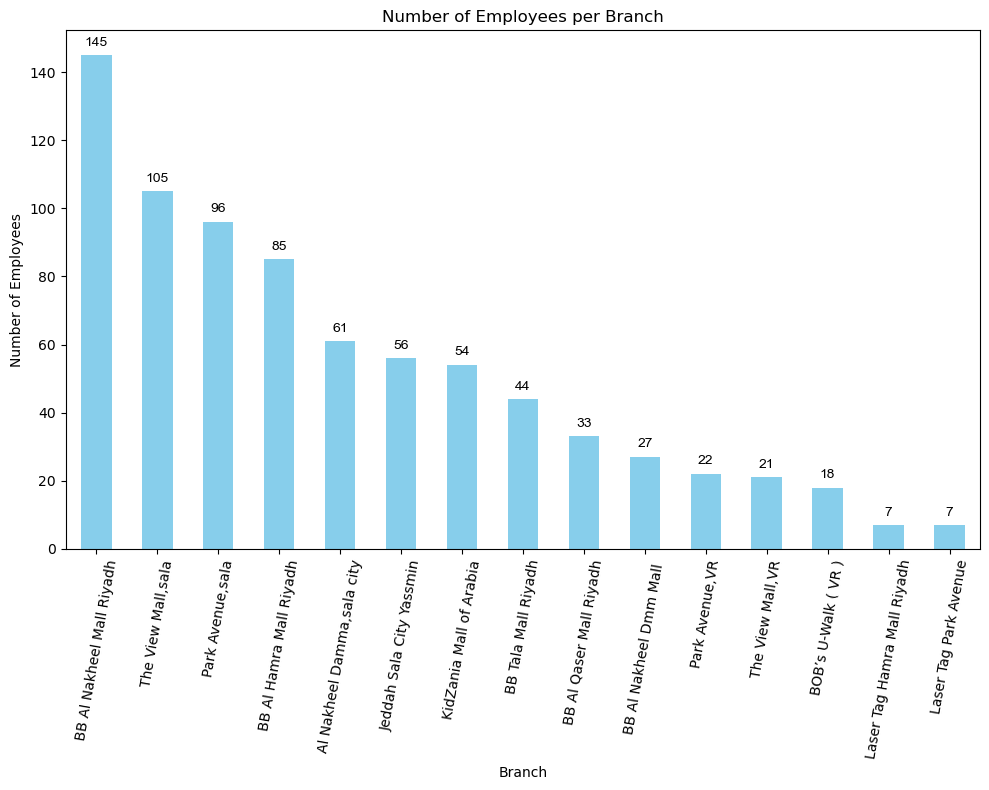

In [ ]:


try:
    # Load the data
    df = pd.read_excel('Sala Attendance.xlsx')

    # Remove any duplicate entries based on 'Worker Phone'
    drop_duplicates = df.drop_duplicates(subset='Worker Phone').copy()

    # Clean non-printable characters from all string columns in the DataFrame
    for col in drop_duplicates.select_dtypes(include=['object']).columns:
        drop_duplicates[col] = drop_duplicates[col].apply(lambda x: ''.join(filter(str.isprintable, x)) if isinstance(x, str) else x)

    # Handle missing values or errors in 'Branch' column
    if 'Branch' not in drop_duplicates.columns:
        raise ValueError("Missing 'Branch' column in the data.")

    # Ensure 'Shift Date' is in datetime format
    drop_duplicates['Shift Date'] = pd.to_datetime(drop_duplicates['Shift Date'], errors='coerce')

    # Filter branches that have attendance records for more than two months
    branch_duration = drop_duplicates.groupby('Branch')['Shift Date'].apply(lambda x: (x.max() - x.min()).days)
    valid_branches = branch_duration[branch_duration > 60].index

    # Filter the DataFrame to include only valid branches
    valid_data = drop_duplicates[drop_duplicates['Branch'].isin(valid_branches)]

    # Count the number of employees per branch
    employee_counts = valid_data['Branch'].value_counts()

    # Calculate the total number of employees across all branches
    total_employees = employee_counts.sum()

    # Print the total number of employees
    print(f"The total number of employees across all branches is {total_employees}.")

    # Plot the results
    plt.figure(figsize=(10, 8))
    bars = employee_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of Employees per Branch')
    plt.xlabel('Branch')
    plt.ylabel('Number of Employees')
    plt.xticks(rotation=80)
    plt.tight_layout()
    plt.rcParams.update({'font.family': 'Arial'})

    # Add text labels above the bars
    for p in bars.patches:
        plt.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')

    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")


## The status of employee discipline in the branches

In [ ]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_excel('Sala Attendance.xlsx')

# Function to add a default date and convert to datetime while handling errors, then format as 12-hour time
default_date = pd.Timestamp('today').normalize()  # Uses today's date

def convert_and_format(time_col):
    # Assuming time data is in 'HH:MM AM/PM' format
    time_format = '%I:%M %p'
    # Convert date and time to datetime format, specify format explicitly
    datetime_col = pd.to_datetime(df[time_col].apply(lambda x: f"{default_date.date()} {x}" if pd.notna(x) else None), format=f'%Y-%m-%d {time_format}', errors='coerce')
    return datetime_col.dt.strftime(time_format)  # Return in 12-hour format with AM/PM

# Apply conversion and formatting to each time column
for col in ['Shift Start Time', 'Shift End Time', 'Check-in Time', 'Check-out Time']:
    df[col] = convert_and_format(col)

# Function to determine delay status based on datetime comparisons and calculate delayed time
def update_status(row):
    # Convert formatted string back to datetime for comparison, using the same format used for formatting
    shift_start = pd.to_datetime(row['Shift Start Time'], format='%I:%M %p', errors='coerce')
    check_in = pd.to_datetime(row['Check-in Time'], format='%I:%M %p', errors='coerce')
    shift_end = pd.to_datetime(row['Shift End Time'], format='%I:%M %p', errors='coerce')
    check_out = pd.to_datetime(row['Check-out Time'], format='%I:%M %p', errors='coerce')
    delay_time = None  # Initialize the delay time

    if pd.isna(check_in) or pd.isna(shift_start):
        return row['Status'], delay_time
    if (check_in - shift_start).total_seconds() > 900:
        delay_time = (check_in - shift_start).total_seconds() / 60  # Calculate delay in minutes
        return 'Delayed', delay_time
    if pd.isna(check_out) or pd.isna(shift_end):
        return row['Status'], delay_time
    if (check_out - shift_end).total_seconds() > 900:
        delay_time = (check_out - shift_end).total_seconds() / 60  # Calculate delay in minutes
        return 'Delayed', delay_time
    return row['Status'], delay_time

# Apply update_status and split results into two columns
df[['Status', 'Delayed Time']] = df.apply(update_status, axis=1, result_type='expand')

# Aggregate status counts by branch
status_counts = df.groupby(['Branch', 'Status']).size().unstack(fill_value=0)

# Ensure all statuses are present in the DataFrame
for status in ['Disputed', 'Finished', 'No Show', 'Delayed']:
    if status not in status_counts.columns:
        status_counts[status] = 0

# Filter for specific statuses
filtered_status_counts = status_counts.loc[:, ['Disputed', 'No Show', 'Delayed', 'Finished']]

# Calculate the percentage of each status per branch
status_percentages = filtered_status_counts.div(filtered_status_counts.sum(axis=1), axis=0) * 100

# Display the aggregated data
filtered_status_counts

# Display the percentage data
status_percentages , filtered_status_counts


(Status                          Disputed   No Show    Delayed   Finished
 Branch                                                                  
  BB Al Nakheel Mall Riyadh      0.236967  3.933649  20.853081  74.976303
  alhofuf,BB Al Hasa Mall \t     0.000000  2.500000  20.000000  77.500000
 Al Nakheel Damma,sala city      0.668151  2.004454   9.576837  87.750557
 BB Al Aziz Mall Jeddah          0.000000  0.485437   3.883495  95.631068
 BB Al Haifa Mall Jeddah         0.000000  0.000000  10.000000  90.000000
 BB Al Hamra Mall Riyadh         0.000000  1.869688   6.798867  91.331445
 BB Al Jubail Mall               1.739130  0.000000  13.913043  84.347826
 BB Al Nakheel Dmm Mall          0.352113  1.408451  10.563380  87.676056
 BB Al Qaser Mall Riyadh         0.302572  0.832073   5.068079  93.797277
 BB Al Yasmin Mall,Jeddah        0.000000  1.709402   7.264957  91.025641
 BB Makkah Mall                  0.000000  5.714286  31.428571  62.857143
 BB Mall of Arabia,Jeddah        0.000

In [ ]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_excel('Sala Attendance.xlsx')

# Function to add a default date and convert to datetime while handling errors, then format as 12-hour time
default_date = pd.Timestamp('today').normalize()  # Uses today's date

def convert_and_format(time_col):
    # Assuming time data is in 'HH:MM AM/PM' format
    time_format = '%I:%M %p'
    # Convert date and time to datetime format, specify format explicitly
    datetime_col = pd.to_datetime(df[time_col].apply(lambda x: f"{default_date.date()} {x}" if pd.notna(x) else None), format=f'%Y-%m-%d {time_format}', errors='coerce')
    return datetime_col.dt.strftime(time_format)  # Return in 12-hour format with AM/PM

# Apply conversion and formatting to each time column
df['Shift Start Time'] = convert_and_format('Shift Start Time')
df['Shift End Time'] = convert_and_format('Shift End Time')
df['Check-in Time'] = convert_and_format('Check-in Time')
df['Check-out Time'] = convert_and_format('Check-out Time')

# Function to determine delay status based on datetime comparisons and calculate delayed time
def update_status(row):
    # Convert formatted string back to datetime for comparison, using the same format used for formatting
    shift_start = pd.to_datetime(row['Shift Start Time'], format='%I:%M %p', errors='coerce')
    check_in = pd.to_datetime(row['Check-in Time'], format='%I:%M %p', errors='coerce')
    shift_end = pd.to_datetime(row['Shift End Time'], format='%I:%M %p', errors='coerce')
    check_out = pd.to_datetime(row['Check-out Time'], format='%I:%M %p', errors='coerce')
    delay_time = None  # Initialize the delay time

    if pd.isna(check_in) or pd.isna(shift_start):
        return row['Status'], delay_time
    if (check_in - shift_start).total_seconds() > 900:
        delay_time = (check_in - shift_start).total_seconds() / 60  # Calculate delay in minutes
        return 'Delayed', delay_time
    if pd.isna(check_out) or pd.isna(shift_end):
        return row['Status'], delay_time
    if (check_out - shift_end).total_seconds() > 900:
        delay_time = (check_out - shift_end).total_seconds() / 60  # Calculate delay in minutes
        return 'Delayed', delay_time
    return row['Status'], delay_time

# Apply update_status and split results into two columns
df[['Status', 'Delayed Time']] = df.apply(update_status, axis=1, result_type='expand')

# Aggregate status counts by branch
status_counts = df.groupby(['Branch', 'Status']).size().unstack(fill_value=0)

# Ensure all statuses are present in the DataFrame
for status in ['Disputed', 'Finished', 'No Show', 'Delayed']:
    if status not in status_counts.columns:
        status_counts[status] = 0

# Filter for specific statuses
filtered_status_counts = status_counts.loc[:, ['Disputed', 'Finished', 'No Show', 'Delayed']]

# Convert counts to percentages
status_percentages = filtered_status_counts.div(filtered_status_counts.sum(axis=1), axis=0) * 100

# Format the DataFrame to display percentages with a '%' sign
formatted_status_percentages = status_percentages.style.format("{:.2f}%")

# Display the formatted percentage data
formatted_status_percentages


Status,Disputed,Finished,No Show,Delayed
Branch,,,,
BB Al Nakheel Mall Riyadh,0.24%,74.98%,3.93%,20.85%
"alhofuf,BB Al Hasa Mall",0.00%,77.50%,2.50%,20.00%
"Al Nakheel Damma,sala city",0.67%,87.75%,2.00%,9.58%
BB Al Aziz Mall Jeddah,0.00%,95.63%,0.49%,3.88%
BB Al Haifa Mall Jeddah,0.00%,90.00%,0.00%,10.00%
BB Al Hamra Mall Riyadh,0.00%,91.33%,1.87%,6.80%
BB Al Jubail Mall,1.74%,84.35%,0.00%,13.91%
BB Al Nakheel Dmm Mall,0.35%,87.68%,1.41%,10.56%
BB Al Qaser Mall Riyadh,0.30%,93.80%,0.83%,5.07%


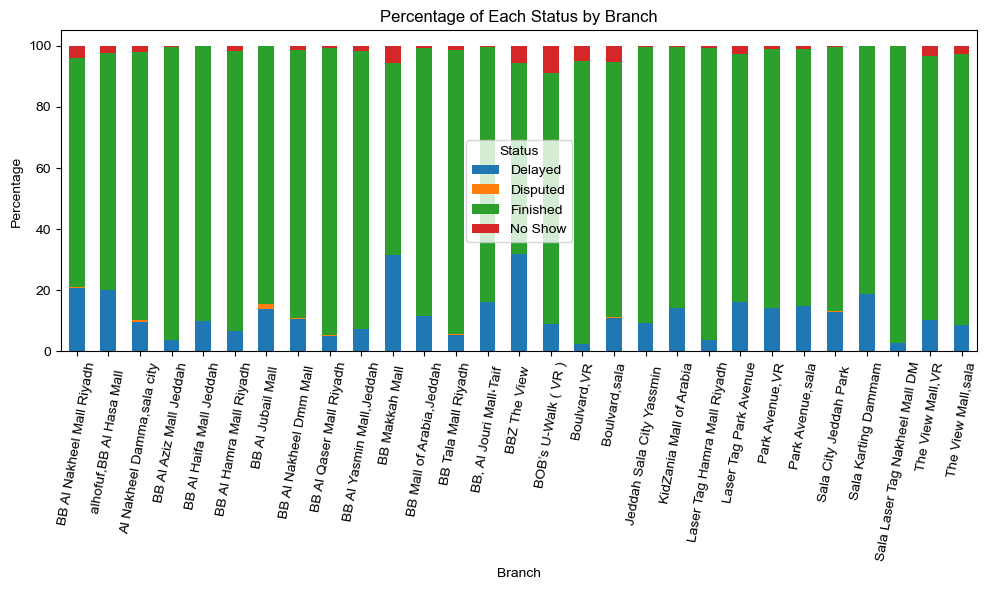

In [ ]:
# Function to add a default date and convert to datetime while handling errors, then format as 12-hour time
default_date = pd.Timestamp('today').normalize()  # Uses today's date

def convert_and_format(time_col):
    # Assuming time data is in 'HH:MM AM/PM' format
    time_format = '%I:%M %p'
    # Convert date and time to datetime format, specify format explicitly
    datetime_col = pd.to_datetime(df[time_col].apply(lambda x: f"{default_date.date()} {x}" if pd.notna(x) else None), format=f'%Y-%m-%d {time_format}', errors='coerce')
    return datetime_col.dt.strftime(time_format)  # Return in 12-hour format with AM/PM

# Apply conversion and formatting to each time column
df['Shift Start Time'] = convert_and_format('Shift Start Time')
df['Shift End Time'] = convert_and_format('Shift End Time')
df['Check-in Time'] = convert_and_format('Check-in Time')
df['Check-out Time'] = convert_and_format('Check-out Time')

# Function to determine delay status based on datetime comparisons and calculate delayed time
def update_status(row):
    # Convert formatted string back to datetime for comparison, using the same format used for formatting
    shift_start = pd.to_datetime(row['Shift Start Time'], format='%I:%M %p', errors='coerce')
    check_in = pd.to_datetime(row['Check-in Time'], format='%I:%M %p', errors='coerce')
    shift_end = pd.to_datetime(row['Shift End Time'], format='%I:%M %p', errors='coerce')
    check_out = pd.to_datetime(row['Check-out Time'], format='%I:%M %p', errors='coerce')
    delay_time = None  # Initialize the delay time

    if pd.isna(check_in) or pd.isna(shift_start):
        return row['Status'], delay_time
    if (check_in - shift_start).total_seconds() > 900:
        delay_time = (check_in - shift_start).total_seconds() / 60  # Calculate delay in minutes
        return 'Delayed', delay_time
    if pd.isna(check_out) or pd.isna(shift_end):
        return row['Status'], delay_time
    if (check_out - shift_end).total_seconds() > 900:
        delay_time = (check_out - shift_end).total_seconds() / 60  # Calculate delay in minutes
        return 'Delayed', delay_time
    return row['Status'], delay_time

# Apply update_status and split results into two columns
df[['Status', 'Delayed Time']] = df.apply(update_status, axis=1, result_type='expand')

# Clean up data to remove or replace tabs in string columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(lambda x: x.replace('\t', ' ') if isinstance(x, str) else x)

# Group by Branch and Status, then count occurrences
status_counts = df.groupby(['Branch', 'Status']).size().unstack(fill_value=0)

# Calculate percentages
status_percentages = status_counts.div(status_counts.sum(axis=1), axis=0) * 100

# Set the default font to Arial to ensure wide character support
plt.rcParams['font.sans-serif'] = ['Arial']

# Plotting the percentages in a stacked bar chart
status_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage of Each Status by Branch')
plt.xlabel('Branch')
plt.ylabel('Percentage')
plt.legend(title='Status')
plt.xticks(rotation=80)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()

## What is the highest number of shifts per month ?

In [ ]:
# Assuming 'df' is your DataFrame and it has been loaded previously

# Ensure the 'Shift Date' column is in datetime format
df['Shift Date'] = pd.to_datetime(df['Shift Date'])

# Extract the year from the 'Shift Date'
df['Year'] = df['Shift Date'].dt.year

# Extract the month from the 'Shift Date'
df['Month'] = df['Shift Date'].dt.month

# Optionally, create a combined 'Year-Month' column for grouped analysis
df['Year-Month'] = df['Shift Date'].dt.to_period('M')

# Display the first few rows to verify the changes
print(df.head())

          Branch                      Worker  Worker Phone Shift Date  \
0  Boulvard,sala           سيف خالد التميمي   966558003307 2023-05-24   
1  Boulvard,sala  عبدالله عبدالعزيز العصيمي   966563239646 2023-05-24   
2  Boulvard,sala      محمد عبدالله سعيد عبيد  966557773504 2023-05-24   
3  Boulvard,sala  عبدالرحيم دخيل علي الهذلي   966536609404 2023-05-24   
4  Boulvard,sala      منصور علي فالح النخلي   966500879622 2023-05-24   

  Shift Start Time Shift End Time Check-in Time Check-out Time  \
0         09:00 PM       01:00 AM      09:00 PM       01:00 AM   
1         09:00 PM       01:00 AM      09:00 PM       01:00 AM   
2         09:00 PM       01:00 AM      09:00 PM       01:00 AM   
3         09:00 PM       01:00 AM      09:00 PM       01:00 AM   
4         09:00 PM       01:00 AM      09:00 PM       01:00 AM   

  System Checkout    Status  Delayed Time in Minutes  Delayed Time  Year  \
0             NaN  Finished                      NaN           NaN  2023   
1           

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame and it has been loaded and prepared with 'Shift Date' as datetime

# Ensure the 'Shift Date' column is in datetime format
df['Shift Date'] = pd.to_datetime(df['Shift Date'])

# Extract the year and month from the 'Shift Date'
df['Year'] = df['Shift Date'].dt.year
df['Month'] = df['Shift Date'].dt.month

# Assuming there is a 'Status' column in your DataFrame
# Filter the DataFrame to include only rows where the status is 'Finished' or 'Delayed'
filtered_df = df[df['Status'].isin(['Finished', 'Delayed'])]

# Group by 'Year' and 'Month' and count the entries
monthly_counts = filtered_df.groupby(['Year', 'Month']).size()

# Convert the groupby object to a DataFrame and provide a column name for the counts
monthly_counts_df = monthly_counts.reset_index(name='Count')

# Display the monthly counts
print(monthly_counts_df)


    Year  Month  Count
0   2023      5    471
1   2023      6   1820
2   2023      7   4376
3   2023      8   1518
4   2023      9   1397
5   2023     10   1467
6   2023     11   1718
7   2023     12   1515
8   2024      1   1155
9   2024      2   1148
10  2024      3    634
11  2024      4   1229
12  2024      5    264


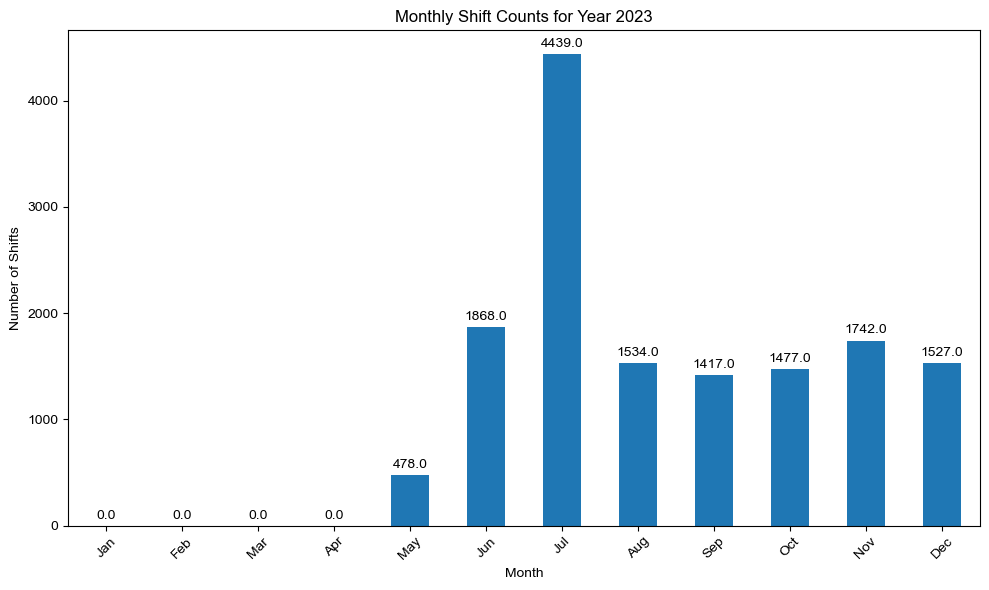

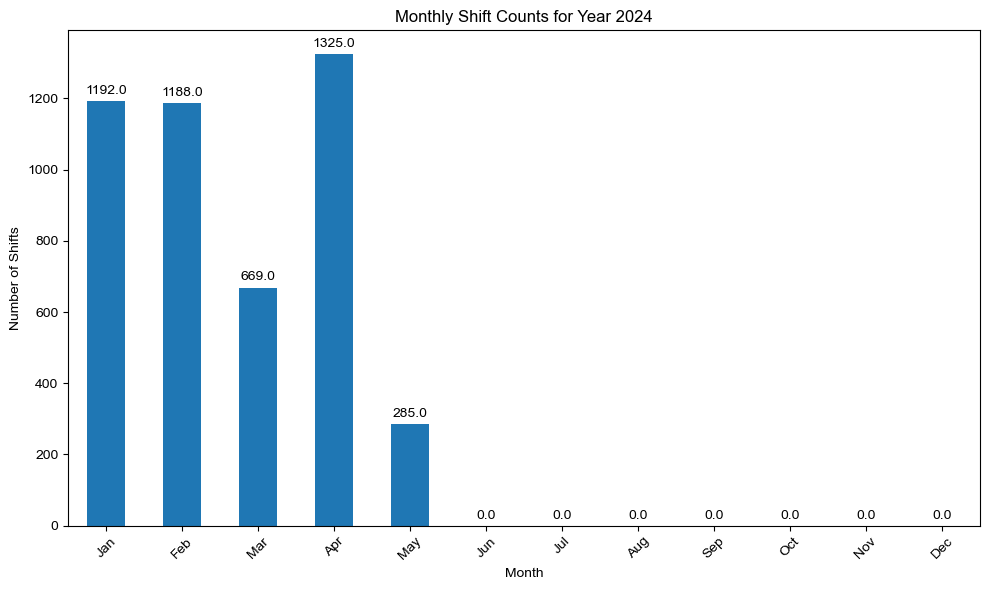

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the 'Shift Date' column is in datetime format
df['Shift Date'] = pd.to_datetime(df['Shift Date'])

# Extract the year and month from the 'Shift Date'
df['Year'] = df['Shift Date'].dt.year
df['Month'] = df['Shift Date'].dt.month

# Group by 'Year' and 'Month' and count the entries
monthly_counts = df.groupby(['Year', 'Month']).size()

# Convert the groupby object to a DataFrame and create a proper MultiIndex
monthly_counts_df = monthly_counts.unstack(level=0)  # This pivots the year to columns, month as rows

# Plot each year as a separate bar graph
years = monthly_counts_df.columns
for year in years:
    plt.figure(figsize=(10, 6))
    bars = monthly_counts_df[year].plot(kind='bar')
    plt.title(f'Monthly Shift Counts for Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Number of Shifts')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)  # Set x-axis labels


    # Add the number above each bar
    for bar in bars.patches:
        height = bar.get_height()
        plt.annotate('{}'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


## What are the total working hours for each month ?

In [ ]:
import pandas as pd

# Load the data
df = pd.read_excel('Sala Attendance.xlsx')

# Ensure 'Shift Date' is in datetime format
df['Shift Date'] = pd.to_datetime(df['Shift Date'])

# Define the correct format for time columns
time_format = '%I:%M %p'

# Parse times with specified format
df['Shift Start Time'] = pd.to_datetime(df['Shift Start Time'], format=time_format, errors='coerce').dt.time
df['Shift End Time'] = pd.to_datetime(df['Shift End Time'], format=time_format, errors='coerce').dt.time
df['Check-in Time'] = pd.to_datetime(df['Check-in Time'], format=time_format, errors='coerce').dt.time
df['Check-out Time'] = pd.to_datetime(df['Check-out Time'], format=time_format, errors='coerce').dt.time

# Fill missing 'Check-in Time' with 'Shift Start Time'
df['Check-in Time'] = df.apply(lambda row: row['Shift Start Time'] if pd.isna(row['Check-in Time']) else row['Check-in Time'], axis=1)

# Fill missing 'Check-out Time' with 'Shift End Time'
df['Check-out Time'] = df.apply(lambda row: row['Shift End Time'] if pd.isna(row['Check-out Time']) else row['Check-out Time'], axis=1)

# Combine date and time into a single datetime column
df['Check-in Time'] = pd.to_datetime(df['Shift Date'].astype(str) + ' ' + df['Check-in Time'].astype(str), errors='coerce')
df['Check-out Time'] = pd.to_datetime(df['Shift Date'].astype(str) + ' ' + df['Check-out Time'].astype(str), errors='coerce')

# Correct working hours calculation by handling shifts that span past midnight
df['Check-out Time'] = df.apply(lambda row: row['Check-out Time'] + pd.Timedelta(days=1) if row['Check-out Time'] < row['Check-in Time'] else row['Check-out Time'], axis=1)

# Recalculate working hours for each shift
df['Working Hours'] = (df['Check-out Time'] - df['Check-in Time']).dt.total_seconds() / 3600

# Extract the month from the Shift Date
df['Shift Month'] = df['Shift Date'].dt.to_period('M')

# Sum the working hours for each month
monthly_hours = df.groupby('Shift Month')['Working Hours'].sum().reset_index()

# Find the month with the highest working hours
max_month = monthly_hours.loc[monthly_hours['Working Hours'].idxmax()]

monthly_hours, max_month


(   Shift Month  Working Hours
 0      2023-05    3458.866667
 1      2023-06   14348.433333
 2      2023-07   34703.033333
 3      2023-08   10740.050000
 4      2023-09   11173.833333
 5      2023-10    9877.816667
 6      2023-11   11629.650000
 7      2023-12    9770.516667
 8      2024-01    9441.316667
 9      2024-02    9410.600000
 10     2024-03    4314.916667
 11     2024-04    9448.916667
 12     2024-05    2246.583333,
 Shift Month           2023-07
 Working Hours    34703.033333
 Name: 2, dtype: object)

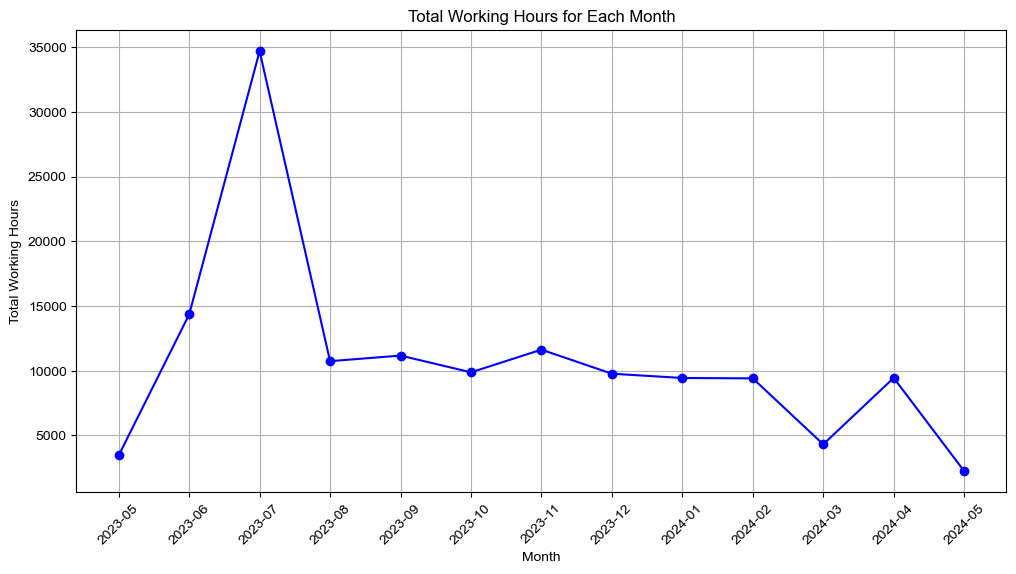

In [ ]:

# Plotting the Total Working Hours for Each Month
plt.figure(figsize=(12, 6))
plt.plot(monthly_hours['Shift Month'].astype(str), monthly_hours['Working Hours'], marker='o', linestyle='-', color='b')
plt.xlabel('Month')
plt.ylabel('Total Working Hours')
plt.title('Total Working Hours for Each Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
